In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
import pandas as pd
df = pd.read_csv('/content/gdrive/My Drive/Mestrado/pre_processing_important.csv')

In [4]:

from sklearn.neighbors import NearestNeighbors
import random


def get_minority_samples(X: pd.DataFrame, y: pd.DataFrame, ql=[0.05, 1.]):
    """
    return
    X_sub: pandas.DataFrame, the feature vector minority dataframe
    y_sub: pandas.DataFrame, the target vector minority dataframe
    """

    def get_tail_label(df):
      """
      Give tail label colums of the given target dataframe
      
      args
      df: pandas.DataFrame, target label df whose tail label has to identified
      
      return
      tail_label: list, a list containing column name of all the tail label
      """
      columns = df.columns
      n = len(columns)
      irpl = np.zeros(n)
      for column in range(n):
          irpl[column] = df[columns[column]].value_counts()[1]
      irpl = max(irpl)/irpl
      mir = np.average(irpl)
      tail_label = []
      for i in range(n):
          if irpl[i] > mir:
              tail_label.append(columns[i])
      return tail_label

    
    tail_labels = get_tail_label(y, ql=ql)
    print(set(tail_labels))
    index = y[y[tail_labels].apply(lambda x: (x == 1).any(), axis=1)].index.tolist()
    
    X_sub = X[X.index.isin(index)].reset_index(drop = True)
    y_sub = y[y.index.isin(index)].reset_index(drop = True)
    return X_sub, y_sub


def nearest_neighbour(X: pd.DataFrame, neigh) -> list:
    """
    Give index of 10 nearest neighbor of all the instance
    
    args
    X: np.array, array whose nearest neighbor has to find
    
    return
    indices: list of list, index of 5 NN of each element in X
    """
    nbs = NearestNeighbors(n_neighbors=neigh, metric='euclidean', algorithm='kd_tree').fit(X)
    euclidean, indices = nbs.kneighbors(X)
    return indices


def MLSMOTE(X, y, n_sample = 100, neigh=5):
    """
    Give the augmented data using MLSMOTE algorithm
    
    args
    X: pandas.DataFrame, input vector DataFrame
    y: pandas.DataFrame, feature vector dataframe
    n_sample: int, number of newly generated sample
    
    return
    new_X: pandas.DataFrame, augmented feature vector data
    target: pandas.DataFrame, augmented target vector data
    """
    indices2 = nearest_neighbour(X, neigh=5)
    n = len(indices2)
    new_X = np.zeros((n_sample, X.shape[1]))
    target = np.zeros((n_sample, y.shape[1]))
    for i in range(n_sample):
        reference = random.randint(0, n-1)
        neighbor = random.choice(indices2[reference, 1:])
        all_point = indices2[reference]
        nn_df = y[y.index.isin(all_point)]
        ser = nn_df.sum(axis = 0, skipna = True)
        target[i] = np.array([1 if val > 0 else 0 for val in ser])
        ratio = random.random()
        gap = X.loc[reference,:] - X.loc[neighbor,:]
        new_X[i] = np.array(X.loc[reference,:] + ratio * gap)
    new_X = pd.DataFrame(new_X, columns=X.columns)
    target = pd.DataFrame(target, columns=y.columns)
    return new_X, target

In [5]:
X = df['text_processed']


In [6]:
from ast import literal_eval
df['labels'] = df['labels'].apply(literal_eval)

In [7]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y=mlb.fit_transform(df['labels'])

In [8]:
def get_tail_label(df):
    """
    Give tail label colums of the given target dataframe
    
    args
    df: pandas.DataFrame, target label df whose tail label has to identified
    
    return
    tail_label: list, a list containing column name of all the tail label
    """
    columns = df.columns
    n = len(columns)
    irpl = np.zeros(n)
    for column in range(n):
        irpl[column] = df[columns[column]].value_counts()[1]
    irpl = max(irpl)/irpl
    mir = np.average(irpl)
    tail_label = []
    for i in range(n):
        if irpl[i] > mir:
            tail_label.append(columns[i])
    return tail_label

def get_index(df):
  """
  give the index of all tail_label rows
  args
  df: pandas.DataFrame, target label df from which index for tail label has to identified
    
  return
  index: list, a list containing index number of all the tail label
  """
  tail_labels = get_tail_label(df)
  index = set()
  for tail_label in tail_labels:
    sub_index = set(df[df[tail_label]==1].index)
    index = index.union(sub_index)
  return list(index)

def get_minority_instace(X, y):
    """
    Give minority dataframe containing all the tail labels
    
    args
    X: pandas.DataFrame, the feature vector dataframe
    y: pandas.DataFrame, the target vector dataframe
    
    return
    X_sub: pandas.DataFrame, the feature vector minority dataframe
    y_sub: pandas.DataFrame, the target vector minority dataframe
    """
    index = get_index(y)
    X_sub = X[X.index.isin(index)].reset_index(drop = True)
    y_sub = y[y.index.isin(index)].reset_index(drop = True)
    return X_sub, y_sub

def nearest_neighbour(X, neigh=5):
    """
    Give index of 5 nearest neighbor of all the instance
    
    args
    X: np.array, array whose nearest neighbor has to find
    
    return
    indices: list of list, index of 5 NN of each element in X
    """
    nbs=NearestNeighbors(n_neighbors=5,metric='euclidean',algorithm='kd_tree').fit(X)
    euclidean,indices= nbs.kneighbors(X)
    return indices



def MLSMOTE(X, y, n_sample = 100, neigh=5):
    """
    Give the augmented data using MLSMOTE algorithm
    
    args
    X: pandas.DataFrame, input vector DataFrame
    y: pandas.DataFrame, feature vector dataframe
    n_sample: int, number of newly generated sample
    
    return
    new_X: pandas.DataFrame, augmented feature vector data
    target: pandas.DataFrame, augmented target vector data
    """
    indices2 = nearest_neighbour(X, neigh=5)
    n = len(indices2)
    new_X = np.zeros((n_sample, X.shape[1]))
    target = np.zeros((n_sample, y.shape[1]))
    for i in range(n_sample):
        reference = random.randint(0, n-1)
        neighbor = random.choice(indices2[reference, 1:])
        all_point = indices2[reference]
        nn_df = y[y.index.isin(all_point)]
        ser = nn_df.sum(axis = 0, skipna = True)
        target[i] = np.array([1 if val > 0 else 0 for val in ser])
        ratio = random.random()
        gap = X.loc[reference,:] - X.loc[neighbor,:]
        new_X[i] = np.array(X.loc[reference,:] + ratio * gap)
    new_X = pd.DataFrame(new_X, columns=X.columns)
    target = pd.DataFrame(target, columns=y.columns)
    return new_X, target

In [9]:
! pip install iterative-stratification

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
! pip install scikit-multilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 89 kB 3.6 MB/s 


In [11]:
import pandas as pd
import numpy as np 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer


#using the count vectorizer
count = CountVectorizer()
word_count=count.fit_transform(df['text_processed'])

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count)
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=count.get_feature_names(),columns=["idf_weights"])


#inverse document frequency
df_idf.sort_values(by=['idf_weights'])

#tfidf
tf_idf_vector=tfidf_transformer.transform(word_count)
feature_names = count.get_feature_names()

first_document_vector=tf_idf_vector[1]
df_tfifd= pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"])

df_tfifd.sort_values(by=["tfidf"],ascending=True)

temp = df_tfifd.to_dict()

from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stopwords_nltlk = list(set(stopwords.words('english')))

ultimate = []
for word in stopwords_nltlk:
  if word in temp['tfidf'].keys():
    if temp['tfidf'][word] == 0 :#and word not in do_not_remove:
      ultimate.append(word)

#### add ultimate as stopwords

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [13]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize 
import numpy as np

def average_sentences(X):

    new_X = []
    for instance in X:
      sentences = sent_tokenize(instance)
      current_embedding = embed(sentences).numpy()
      '''
      diff = number -len(current_embedding)
      if diff > 0:
          padding = np.zeros((diff, 512))
          current_embedding = np.concatenate((padding, current_embedding), axis=0)
      '''
      new_X.append(np.mean(current_embedding, axis=0))
      
    
    return np.array(new_X)


from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [14]:
########### paraphrase ##############
!pip install transformers
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 5.2 MB/s 
     |████████████████████████████████| 101 kB 10.1 MB/s 
     |████████████████████████████████| 596 kB 44.2 MB/s 
     |████████████████████████████████| 6.6 MB 62.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 5.3 MB/s 


In [15]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
model = AutoModelForSeq2SeqLM.from_pretrained("ramsrigouthamg/t5-large-paraphraser-diverse-high-quality")
tokenizer = AutoTokenizer.from_pretrained("ramsrigouthamg/t5-large-paraphraser-diverse-high-quality")
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print ("device ",device)
model = model.to(device)

Downloading:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.75G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.81k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

device  cpu


In [16]:
def paraphrase(context):

  text = "" + context + " </s>"
  encoding = tokenizer.encode_plus(text,max_length =128, padding=True, return_tensors="pt")
  input_ids,attention_mask  = encoding["input_ids"].to(device), encoding["attention_mask"].to(device)
  model.eval()
  diverse_beam_outputs = model.generate(
      input_ids=input_ids,attention_mask=attention_mask,
      max_length=128,
      early_stopping=True,
      num_beams=10,
      num_beam_groups = 5,
      num_return_sequences=2,
      diversity_penalty = 0.70
  )

  ans = []
  for beam_output in diverse_beam_outputs:
      sent = tokenizer.decode(beam_output, skip_special_tokens=True,clean_up_tokenization_spaces=True)
      ans.append(sent[len("'paraphrasedoutput:") : ])
  return ans

In [17]:
from nltk.tokenize import sent_tokenize, word_tokenize 
import nltk
import numpy as np
nltk.download('punkt')

def paraphrase_sample(text):
  n = len(sent_tokenize(text))

  result = []
  smallest = 1000

  for sentence in sent_tokenize(text):
    sentence_augments = paraphrase(sentence)

   
    smallest = min(smallest, len(sentence_augments))
    result.append(sentence_augments[0: smallest])


  result = np.array(result).T
  ans = []
  for i in range(len(result)):
    ans.append(' '.join(result[i]))
    #result[i] = ' '.join(result[i])
      
  return ans

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [18]:
def aug(X_train, y_train, index):
  
  X_new = []
  y_new= []

  for X, y in zip(X_train[index], y_train[index]):
    X_new.append(paraphrase_sample(X))
    y_new.append(y)

  return X_new, y_new


In [19]:
X = df['text']

In [20]:
def do(X_train, X_a):
 oop = X_train.tolist()
 for a in X_a:
   print(a[0])
   oop.append(a[0])
 return oop

def do_y(X_train, X_a):
 oop = X_train.tolist()
 for a in X_a:
   
   oop.append(a)
 return oop

In [21]:
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
import numpy as np
from sklearn.feature_extraction.text import TfidfTransformer
from imblearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.multiclass import OneVsRestClassifier ### does not take into account label correlations
from sklearn.svm import SVC
from sklearn.metrics import classification_report, multilabel_confusion_matrix, accuracy_score, hamming_loss, jaccard_score

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#from sklearn.multioutput import ClassifierChain

from sklearn.utils import compute_class_weight
from skmultilearn.problem_transform import BinaryRelevance
from keras.wrappers.scikit_learn import KerasClassifier

from skmultilearn.problem_transform import ClassifierChain, LabelPowerset
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from skmultilearn.cluster import NetworkXLabelGraphClusterer
from skmultilearn.cluster import LabelCooccurrenceGraphBuilder
from skmultilearn.ensemble import LabelSpacePartitioningClassifier

msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)


# linear is nice 0.47
# poly 0.37
# rbf 0.34
# sigmoid 0.43

#from skmultilearn.ext import Keras

from skmultilearn.adapt import MLkNN
from sklearn.model_selection import GridSearchCV


################ run the pipeline #####################

#### RF E LR
for train_index, test_index in msss.split(np.array(X), np.array(y)):
      import warnings
      warnings.simplefilter(action='ignore', category=FutureWarning)
      ####### performing the different splits here #########
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]

      from sklearn.feature_extraction.text import TfidfVectorizer
      
      vectorizer = TfidfVectorizer(analyzer="char_wb", ngram_range=(1,2), use_idf=True, norm='l2', stop_words=ultimate)

      X_train = average_sentences(X_train)  #vectorizer.fit_transform(X_train)
      #df_y =  pd.DataFrame(y_train, columns=mlb.classes_)
      #df_X = pd.DataFrame(data = X_train)

      #X_sub, y_sub = get_minority_instace(df_X, df_y)   #Getting minority instance of that datframe
      #X_res,y_res =MLSMOTE(X_sub, y_sub, 30)  

      print(X_train.shape) 

     
      #X_train_augmented = pd.concat([df_X, X_res])
      #y_train_augmented = pd.concat([df_y, y_res])

      X_test = average_sentences(X_test) #vectorizer.transform(X_test)
      from sklearn.linear_model import LogisticRegression

      #clf = ClassifierChain(LogisticRegression(C=100, solver="liblinear", class_weight="balanced"))
      clf = ClassifierChain(SVC(C= 20, kernel="linear", class_weight = "balanced"))
      clf.fit(X_train, y_train)

      y_pred = clf.predict(X_test)

      from sklearn.metrics import classification_report, jaccard_score, hamming_loss
      print(classification_report(y_test, y_pred))
      print(jaccard_score(y_test, y_pred, average= "weighted"))
      print(hamming_loss(y_test, y_pred))


(366, 512)
              precision    recall  f1-score   support

           0       0.85      0.81      0.83        48
           1       0.91      0.83      0.87        52
           2       0.64      0.81      0.71        26

   micro avg       0.82      0.82      0.82       126
   macro avg       0.80      0.82      0.80       126
weighted avg       0.83      0.82      0.82       126
 samples avg       0.85      0.85      0.82       126

0.7010583818854497
0.17624521072796934


In [37]:
# dates
df2 = pd.read_csv('/content/gdrive/MyDrive/Mestrado/semi_supervised_learning.csv')

In [39]:
df2.shape

(29283, 6)

In [41]:
!pip install matplotlib
!pip install pandas
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


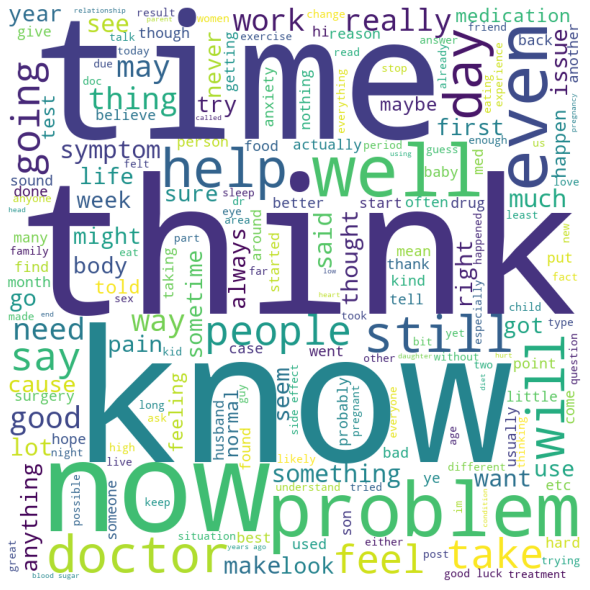

In [44]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
 
# Reads 'Youtube04-Eminem.csv' file
 
comment_words = ''
stopwords = set(STOPWORDS)
stopwords.add('one')
stopwords.add('thing')
 
# iterate through the csv file
for val in df2.text:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()